In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


## 1. Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

## 2. Data Loading and Initial EDA

In [3]:
# Load data
train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')
sample_sub = pd.read_csv('/kaggle/input/System-Threat-Forecaster/sample_submission.csv')

# Initial checks
print(f"Train shape: {train.shape}, \nTest shape: {test.shape}")


Train shape: (100000, 76), 
Test shape: (10000, 75)



**Here, Training Dataset has 100000 rows and 76 Columnswhereas Test Dataset has 10000 rows and 75 Columns**


In [4]:
train.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

**This is giving us information about the columns names, columns having non-null values and Datatype of each columns**

In [6]:
train.describe()

,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,...,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,target
count,100000.0,99934.000000,100000.000000,99924.000000,99924.000000,99924.000000,100000.000000,100000.000000,99377.000000,100000.000000,...,99624.000000,99666.000000,100000.000000,99980.000000,100000.000000,100000.000000,99866.000000,99441.000000,99441.000000,100000.000000
mean,0.0,6.848430,0.017620,47975.710440,1.326528,1.018264,0.996780,108.078790,81029.938587,169.741630,...,401.987613,32942.648044,0.495690,0.003841,0.128470,0.040580,0.058398,0.296668,7.875866,0.505250
std,0.0,1.015166,0.131566,13803.321533,0.520681,0.155291,0.056654,63.062151,48944.027074,89.188929,...,221.318891,21151.970827,0.499984,0.061855,0.334614,0.197316,0.234496,0.456791,4.562533,0.499975
min,0.0,0.000000,0.000000,39.000000,1.000000,0.000000,0.000000,1.000000,7.000000,1.000000,...,2.000000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.0,7.000000,0.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,36694.000000,89.000000,...,142.000000,13020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.0,7.000000,0.000000,53447.000000,1.000000,1.000000,1.000000,97.000000,82373.000000,181.000000,...,500.000000,33066.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000
75%,0.0,7.000000,0.000000,53447.000000,2.000000,1.000000,1.000000,162.000000,122835.000000,267.000000,...,556.000000,52357.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,1.000000
max,0.0,8.000000,1.000000,70490.000000,5.000000,4.000000,1.000000,222.000000,167957.000000,296.000000,...,1083.000000,72091.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000


**Here we can see the basic statistics details of all the numerical Columns**

### Checking missing values

In [7]:
missing_values = train.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values/len(train)*100).round(2)
missing_analysis = pd.concat([missing_values, missing_percent], 
                            axis=1, 
                            keys=['Missing Count', 'Percentage'])
print("Missing Value Analysis:")
print(missing_analysis[missing_analysis['Missing Count'] > 0])

Missing Value Analysis:
                                    Missing Count  Percentage
SMode                                         981        0.98
CityID                                        623        0.62
RegionIdentifier                              559        0.56
IsGamer                                       559        0.56
InternalBatteryNumberOfCharges                515        0.52
FirmwareManufacturerID                        376        0.38
FirmwareVersionID                             334        0.33
IsFlightsDisabled                             326        0.33
OEMModelID                                    228        0.23
OEMNameID                                     212        0.21
FirewallEnabled                               166        0.17
TotalPhysicalRAMMB                            151        0.15
IsAlwaysOnAlwaysConnectedCapable              134        0.13
OSInstallLanguageID                           113        0.11
PrimaryDiskCapacityMB                         


**Here we can see all the columns names as well as their exact count of missing values and percentage of missing** **values.as we can see the missing values of each columns are less than 1 percentage so no need to drop any** **columns**


### Data visualisation

Target distribution:
target
1    50525
0    49475
Name: count, dtype: int64
Percentage of positive class: 50.52%


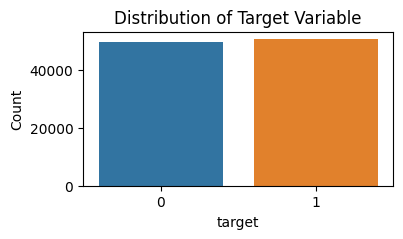

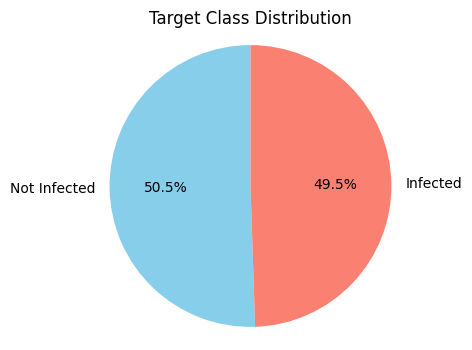

In [8]:
# Check target distribution
target_counts = train['target'].value_counts()
print("Target distribution:")
print(target_counts)
print(f"Percentage of positive class: {train['target'].mean() * 100:.2f}%")

# Visualize target distribution
plt.figure(figsize=(4, 2))
sns.countplot(x='target', data=train)
plt.title('Distribution of Target Variable')
plt.ylabel('Count')
plt.show()

# Pie chart of target distribution
plt.figure(figsize=(4, 4))
plt.pie(target_counts, labels=['Not Infected', 'Infected'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Target Class Distribution')
plt.axis('equal')
plt.show()


**As We can see the distribution of Infected and Non-Infected are comparatively Balanced**
**so we can infer the Data is pretty much Balanced**

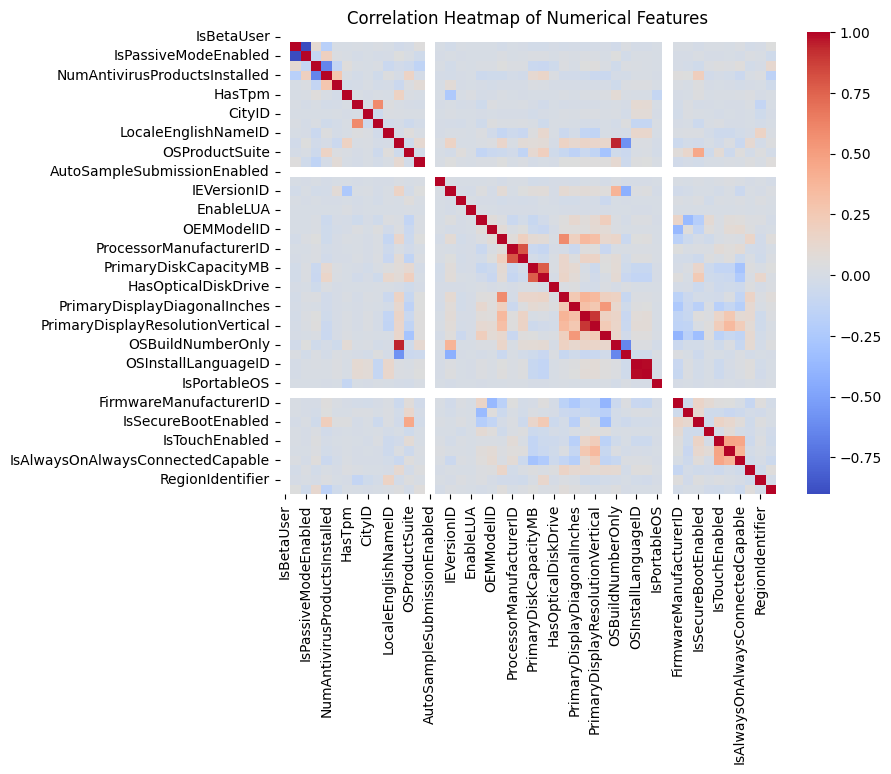

In [9]:
# Correlation heatmap for numerical features
num_features = train.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train[num_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show();

**As We can see many rows are very much correlated like columns like LocaleEnglishNameID is 100% correlated to OsBuildNumberOnly COlumns etc these columns can hinder in giving Optimized Accuracy while Doing Model Training , so need to drop such columns before that.**

## 3. Data Preprocessing

In [10]:
train.columns.tolist()

['MachineID',
 'ProductName',
 'EngineVersion',
 'AppVersion',
 'SignatureVersion',
 'IsBetaUser',
 'RealTimeProtectionState',
 'IsPassiveModeEnabled',
 'AntivirusConfigID',
 'NumAntivirusProductsInstalled',
 'NumAntivirusProductsEnabled',
 'HasTpm',
 'CountryID',
 'CityID',
 'GeoRegionID',
 'LocaleEnglishNameID',
 'PlatformType',
 'Processor',
 'OSVersion',
 'OSBuildNumber',
 'OSProductSuite',
 'OsPlatformSubRelease',
 'OSBuildLab',
 'SKUEditionName',
 'IsSystemProtected',
 'AutoSampleSubmissionEnabled',
 'SMode',
 'IEVersionID',
 'FirewallEnabled',
 'EnableLUA',
 'MDC2FormFactor',
 'DeviceFamily',
 'OEMNameID',
 'OEMModelID',
 'ProcessorCoreCount',
 'ProcessorManufacturerID',
 'ProcessorModelID',
 'PrimaryDiskCapacityMB',
 'PrimaryDiskType',
 'SystemVolumeCapacityMB',
 'HasOpticalDiskDrive',
 'TotalPhysicalRAMMB',
 'ChassisType',
 'PrimaryDisplayDiagonalInches',
 'PrimaryDisplayResolutionHorizontal',
 'PrimaryDisplayResolutionVertical',
 'PowerPlatformRole',
 'InternalBatteryNumberOf

In [11]:
test.columns.tolist()

['MachineID',
 'ProductName',
 'EngineVersion',
 'AppVersion',
 'SignatureVersion',
 'IsBetaUser',
 'RealTimeProtectionState',
 'IsPassiveModeEnabled',
 'AntivirusConfigID',
 'NumAntivirusProductsInstalled',
 'NumAntivirusProductsEnabled',
 'HasTpm',
 'CountryID',
 'CityID',
 'GeoRegionID',
 'LocaleEnglishNameID',
 'PlatformType',
 'Processor',
 'OSVersion',
 'OSBuildNumber',
 'OSProductSuite',
 'OsPlatformSubRelease',
 'OSBuildLab',
 'SKUEditionName',
 'IsSystemProtected',
 'AutoSampleSubmissionEnabled',
 'SMode',
 'IEVersionID',
 'FirewallEnabled',
 'EnableLUA',
 'MDC2FormFactor',
 'DeviceFamily',
 'OEMNameID',
 'OEMModelID',
 'ProcessorCoreCount',
 'ProcessorManufacturerID',
 'ProcessorModelID',
 'PrimaryDiskCapacityMB',
 'PrimaryDiskType',
 'SystemVolumeCapacityMB',
 'HasOpticalDiskDrive',
 'TotalPhysicalRAMMB',
 'ChassisType',
 'PrimaryDisplayDiagonalInches',
 'PrimaryDisplayResolutionHorizontal',
 'PrimaryDisplayResolutionVertical',
 'PowerPlatformRole',
 'InternalBatteryNumberOf

### Feature Engineering

In [12]:
# Finding common columns between train and test data
common_cols = list(set(train.columns) & set(test.columns))
common_cols.sort()

# Convert the list of common columns into a DataFrame
df_common_cols = pd.DataFrame(common_cols, columns=['Common Columns'])


display(df_common_cols)

,Common Columns
0,AntivirusConfigID
1,AppVersion
2,AutoSampleSubmissionEnabled
3,AutoUpdateOptionsName
4,ChassisType
...,...
70,SKUEditionName
71,SMode
72,SignatureVersion
73,SystemVolumeCapacityMB


### Separating Categorical , Numerical and Datetime features

In [13]:
# Separate features by type
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Safely remove columns that shouldn't be treated as numeric features
for col in ['target', 'MachineID', 'DateAS', 'DateOS']:
    if col in numeric_features:
        numeric_features.remove(col)

# Extract categorical features
categorical_features = train.select_dtypes(include=['object']).columns.tolist()

# Define date columns explicitly
date_features = ['DateAS', 'DateOS']

# Output the modified lists for verification
print("Numeric Features:", numeric_features)

print("\nCategorical Features:", categorical_features)

print("\nDate Features:", date_features)

Numeric Features: ['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled', 'AntivirusConfigID', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'IsSystemProtected', 'AutoSampleSubmissionEnabled', 'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID', 'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB', 'HasOpticalDiskDrive', 'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges', 'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSInstallLanguageID', 'OSUILocaleID', 'IsPortableOS', 'IsFlightsDisabled', 'FirmwareManufacturerID', 'FirmwareVersionID', 'IsSecureBootEnabled', 'IsVirtualDevice', 'IsTouchEnabled', 'IsPenCapable', 'IsAlwaysOnAlwaysConnectedCapable', 'IsGam

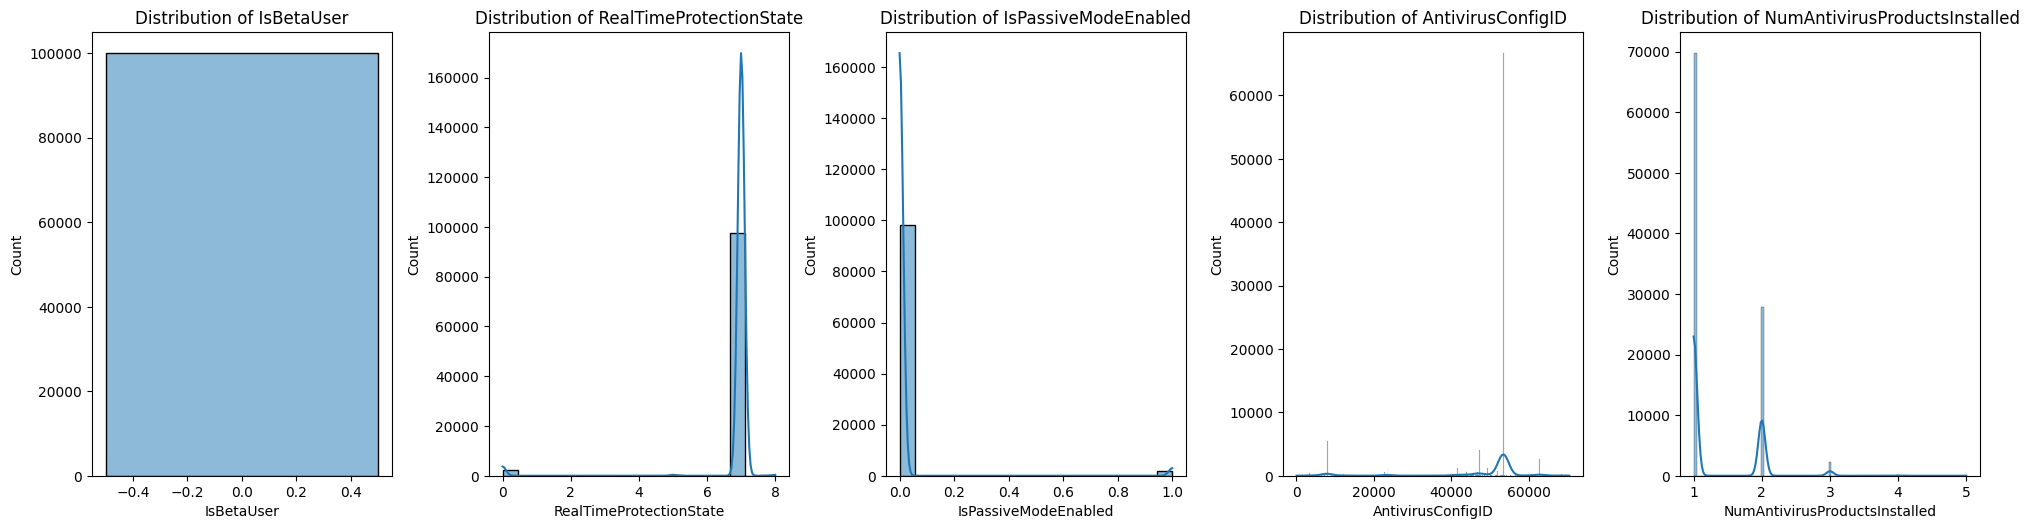

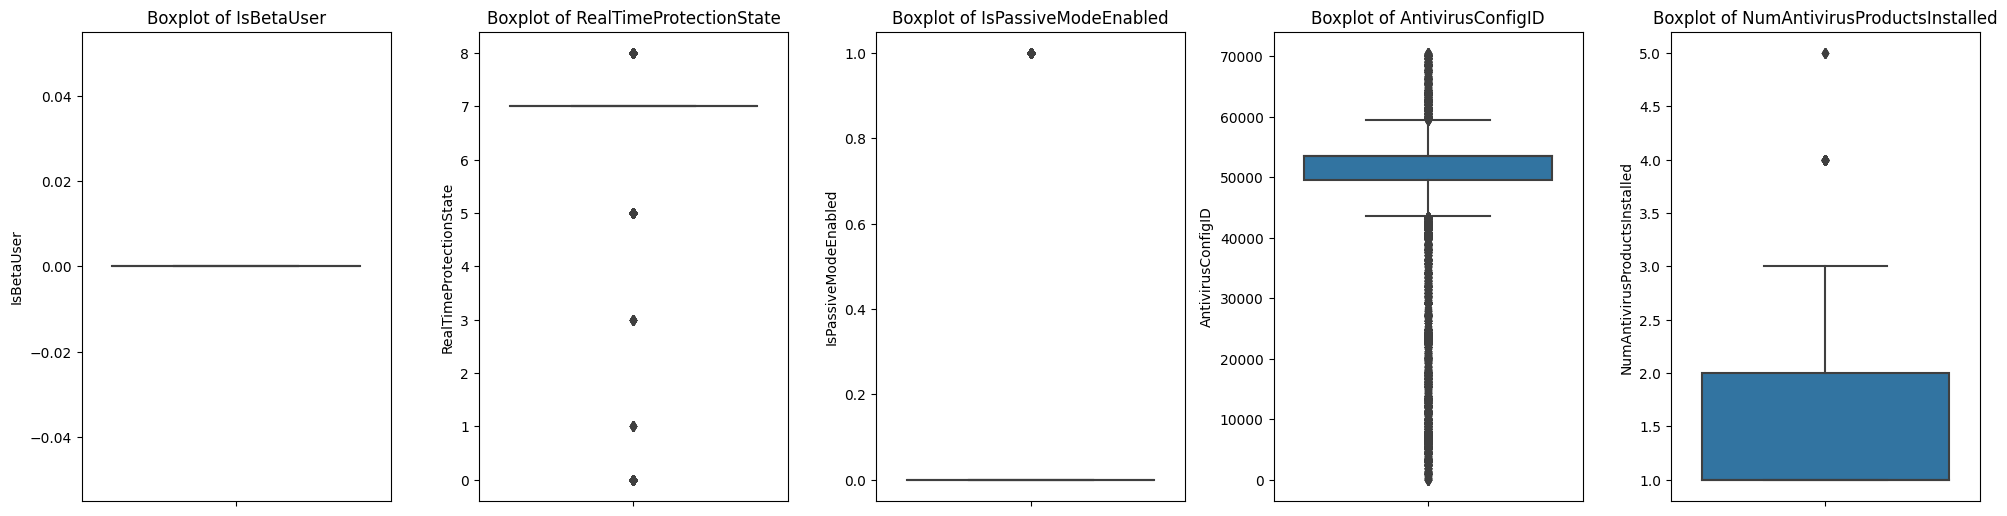

In [14]:
#Visualizing numerical variable
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features[:5]): 
    plt.subplot(3, 5, i+1)
    sns.histplot(train[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Boxplots for numeric features to identify outliers
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features[:5]):
    plt.subplot(3, 5, i+1)
    sns.boxplot(y=train[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

**As we can see most Features Is Skewed, either Left-Skewed or Right-Skewed and also they have outliers**

### Visualizing Categorical features

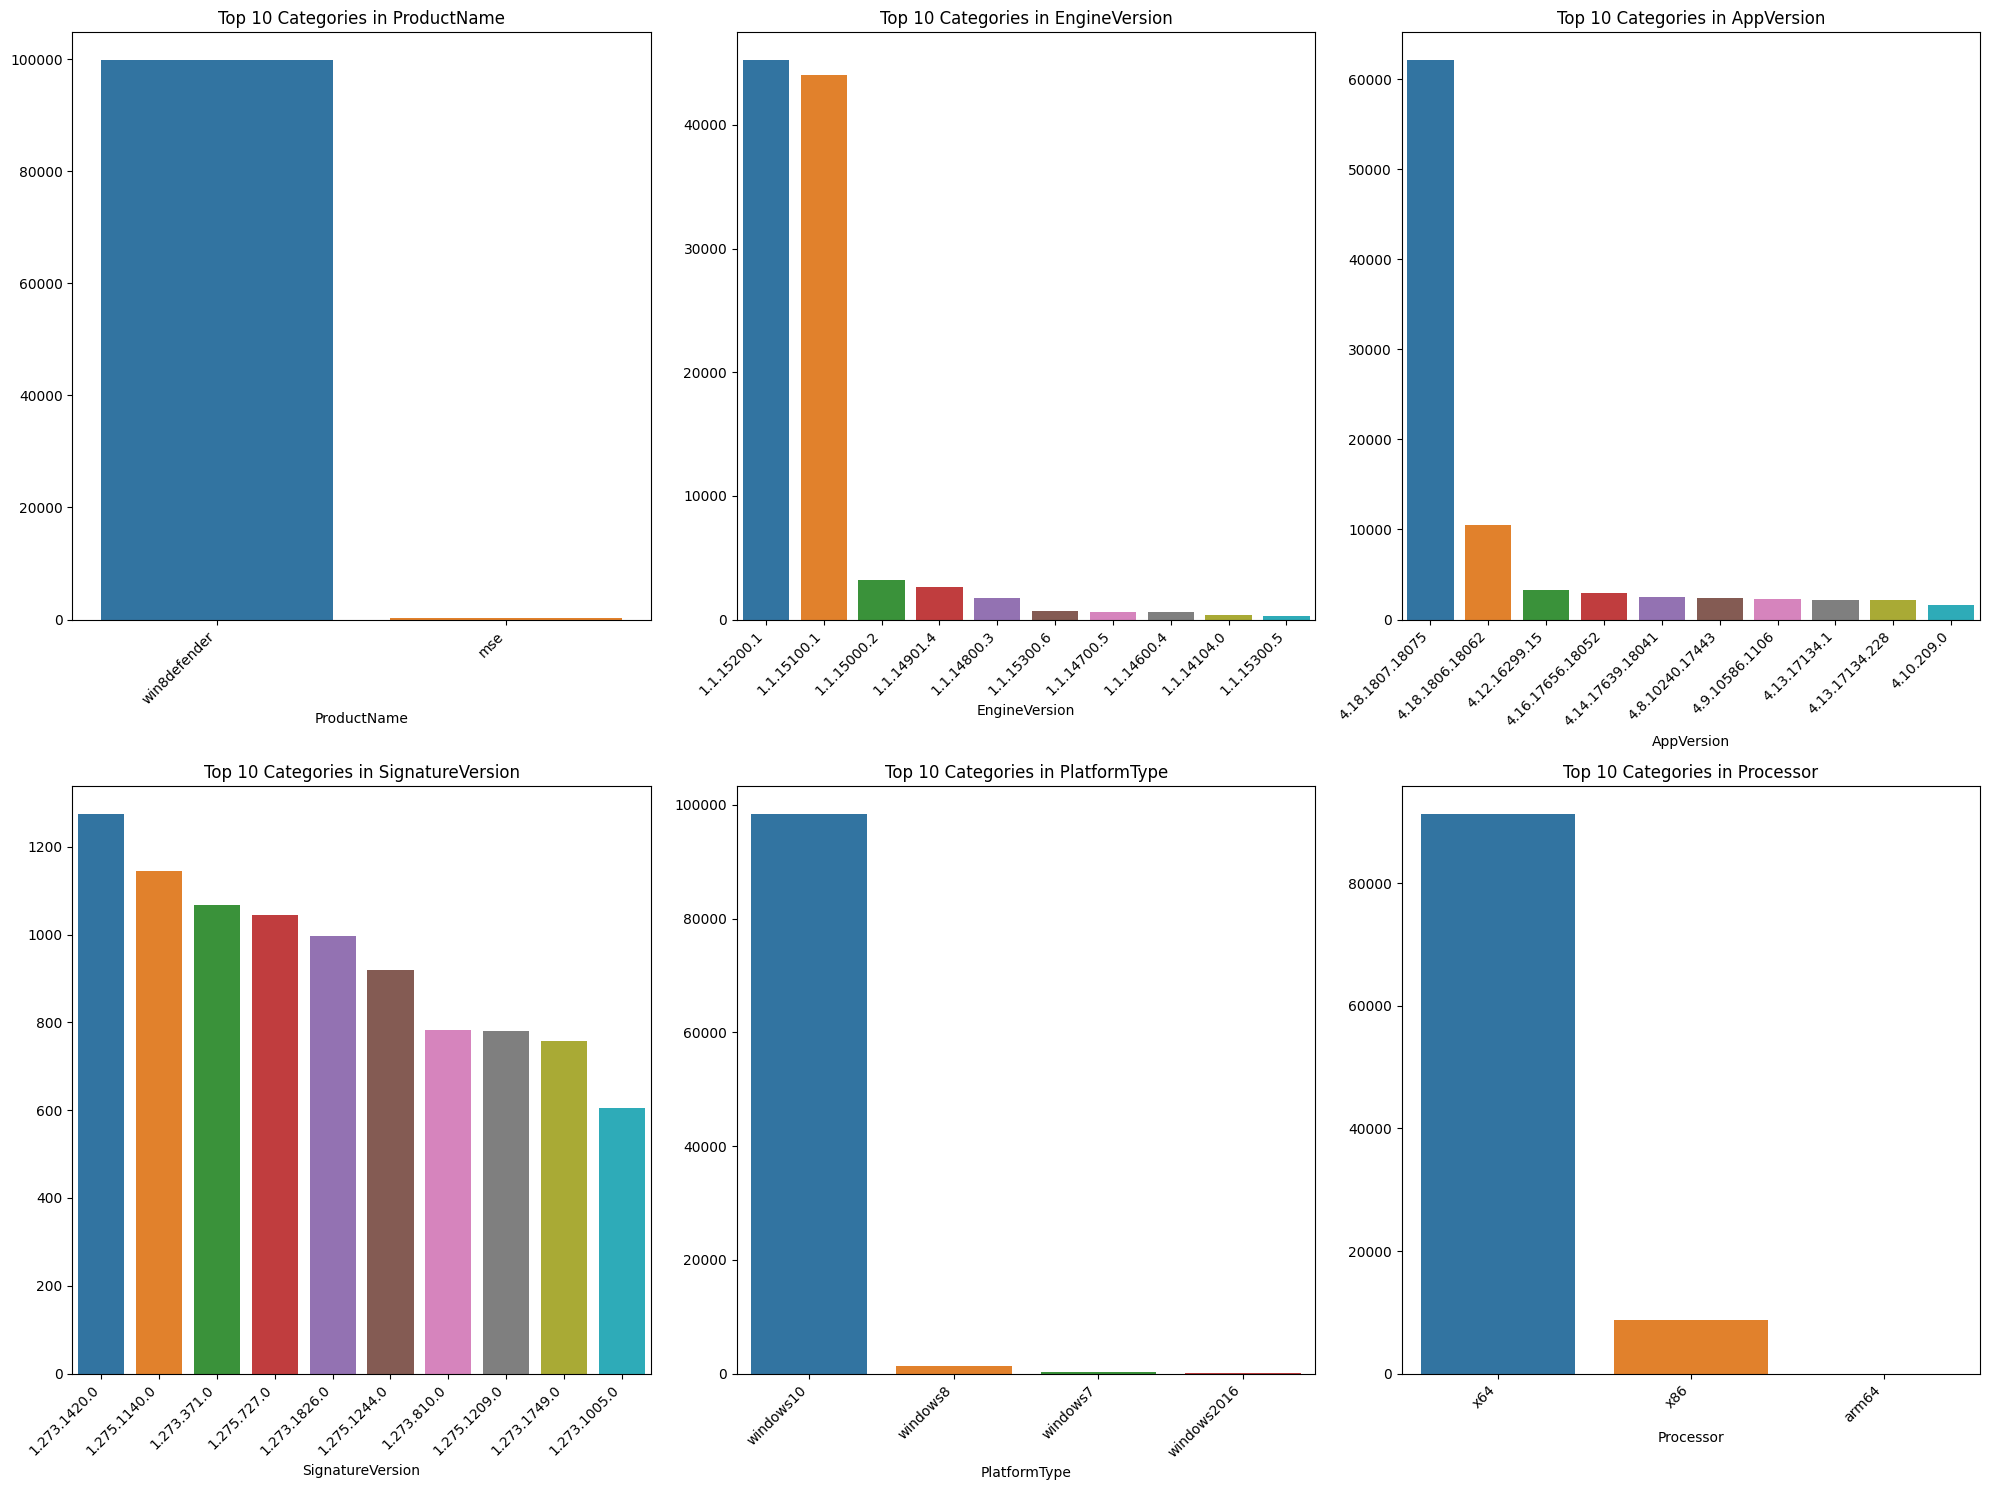

In [15]:
# Analyze categorical features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features[1:7]):  
    plt.subplot(2, 3, i+1)
    value_counts = train[feature].value_counts().nlargest(10)
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Top 10 Categories in {feature}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

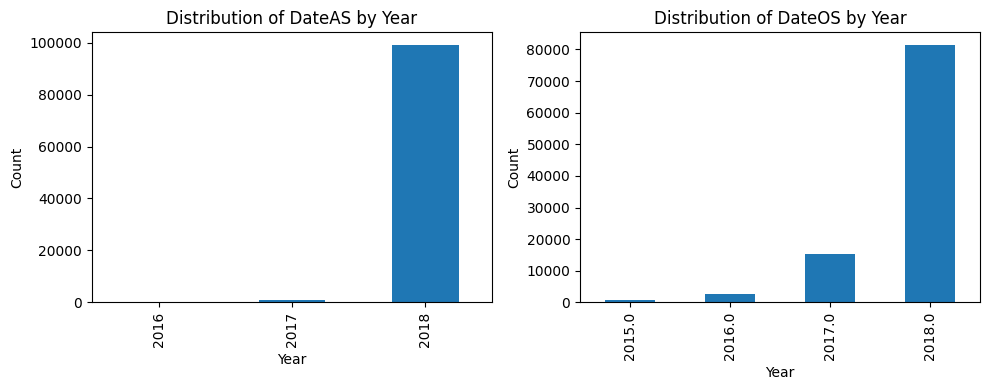

In [16]:
# Convert date columns to datetime
for date_col in date_features:
    if date_col in train.columns:
        train[date_col] = pd.to_datetime(train[date_col])

# Visualize the date distributions
plt.figure(figsize=(10, 4))
for i, date_col in enumerate(date_features):
    if date_col in train.columns:
        plt.subplot(1, 2, i+1)
        train[date_col].dt.year.value_counts().sort_index().plot(kind='bar')
        plt.title(f'Distribution of {date_col} by Year')
        plt.xlabel('Year')
        plt.ylabel('Count')
plt.tight_layout()
plt.show();

### comparing missing values btw Training and Test dataset

In [17]:
train_missing = train.isnull().sum().sort_values(ascending=False)
test_missing = test.isnull().sum().sort_values(ascending=False)

print("Missing values in training set:")
print(train_missing)
print("\nMissing values in testing set:")
print(test_missing)

Missing values in training set:
SMode                             981
CityID                            623
RegionIdentifier                  559
IsGamer                           559
InternalBatteryNumberOfCharges    515
                                 ... 
DeviceFamily                        0
ProductName                         0
HasOpticalDiskDrive                 0
PowerPlatformRole                   0
target                              0
Length: 76, dtype: int64

Missing values in testing set:
SMode                             92
RegionIdentifier                  62
IsGamer                           62
CityID                            61
InternalBatteryNumberOfCharges    54
                                  ..
CountryID                          0
PowerPlatformRole                  0
HasTpm                             0
NumericOSVersion                   0
MachineID                          0
Length: 75, dtype: int64


**As we can see different columns in training have higher missing values as compare to test dataset**
**We need to fill these missing values so after then we can use these datasets in model training**

#### Filling missing values in numerical features with median and categorical features with mode

In [18]:
from sklearn.impute import SimpleImputer

#Impute numerical columns with median
num_imputer = SimpleImputer(strategy='median')
train[numeric_features] = num_imputer.fit_transform(train[numeric_features])
test[numeric_features] = num_imputer.transform(test[numeric_features])

In [19]:
#Impute categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
train[categorical_features] = cat_imputer.fit_transform(train[categorical_features])
test[categorical_features] = cat_imputer.transform(test[categorical_features])

In [20]:
# Check for missing values in train dataset 
print("Missing Values in Training Data After Imputation:")
print(train.isna().sum().sum())  # Expected to be 0

# Check for missing values in test dataset
print("Missing Values in Test Data After Imputation:")
print(test.isna().sum().sum())  # Expected to be 0

Missing Values in Training Data After Imputation:
0
Missing Values in Test Data After Imputation:
0



**We have sucessfully removed all the missing values from Training as well as Test DatasetNow we dont have any missing values so we can proceed to next step**


### Encoding Categorical Features
**since Algorithams only understand the numerical values and our categorical features and many so we can't go for One-Hot encoder , LabelEncoder is better option here to convert text values into numerical values**

In [21]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
for col in categorical_features:
    # Fit on training data
    label_encoder = LabelEncoder()
    train[col] = label_encoder.fit_transform(train[col])
    
    # Transform test data, assigning -1 to unseen categories
    test[col] = test[col].apply(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)

In [22]:
# Target Encoding: 
target_encoded_cols = {}  
for col in categorical_features:  
    target_mean = train.groupby(col)['target'].mean().to_dict()  
    target_encoded_cols[col + '_TargetEnc'] = train[col].map(target_mean)  
    test[col + '_TargetEnc'] = test[col].map(target_mean).fillna(train['target'].mean())  

# Add all target-encoded columns to train at once  
train = pd.concat([train, pd.DataFrame(target_encoded_cols)], axis=1)  


In [23]:
# Frequency Encoding:  
freq_encoded_cols = {}  
for col in categorical_features:  
    freq = train[col].value_counts(normalize=True).to_dict()  
    freq_encoded_cols[col + '_FreqEnc'] = train[col].map(freq)  
    test[col + '_FreqEnc'] = test[col].map(freq).fillna(0)  

# Add all frequency-encoded columns to train at once  
train = pd.concat([train, pd.DataFrame(freq_encoded_cols)], axis=1)  


In [24]:
# Calculate correlation matrix
correlation_matrix = train.corr()

# Remove highly correlated features
correlation_threshold = 0.9
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

#Removing highly correlated features from both train as well as test dataset
train = train.drop(columns=correlated_features)
test = test.drop(columns=correlated_features)

print(f"Removed {len(correlated_features)} highly correlated features:")
print(correlated_features)

Removed 25 highly correlated features:
{'OSSkuFriendlyName_FreqEnc', 'PlatformType_FreqEnc', 'Processor_FreqEnc', 'Processor_TargetEnc', 'OSEdition', 'OSUILocaleID', 'OSSkuFriendlyName', 'NumericOSVersion', 'DeviceFamily_TargetEnc', 'OSVersion', 'MachineID_TargetEnc', 'ProductName_FreqEnc', 'OSArchitecture_FreqEnc', 'DateAS_FreqEnc', 'OSVersion_FreqEnc', 'OSSkuFriendlyName_TargetEnc', 'DateAS_TargetEnc', 'OSArchitecture', 'DeviceFamily_FreqEnc', 'OSArchitecture_TargetEnc', 'SKUEditionName_FreqEnc', 'PrimaryDiskType_FreqEnc', 'IsPassiveModeEnabled', 'ProductName_TargetEnc', 'OSBuildNumberOnly'}


In [25]:
train.columns.to_list()

['MachineID',
 'ProductName',
 'EngineVersion',
 'AppVersion',
 'SignatureVersion',
 'IsBetaUser',
 'RealTimeProtectionState',
 'AntivirusConfigID',
 'NumAntivirusProductsInstalled',
 'NumAntivirusProductsEnabled',
 'HasTpm',
 'CountryID',
 'CityID',
 'GeoRegionID',
 'LocaleEnglishNameID',
 'PlatformType',
 'Processor',
 'OSBuildNumber',
 'OSProductSuite',
 'OsPlatformSubRelease',
 'OSBuildLab',
 'SKUEditionName',
 'IsSystemProtected',
 'AutoSampleSubmissionEnabled',
 'SMode',
 'IEVersionID',
 'FirewallEnabled',
 'EnableLUA',
 'MDC2FormFactor',
 'DeviceFamily',
 'OEMNameID',
 'OEMModelID',
 'ProcessorCoreCount',
 'ProcessorManufacturerID',
 'ProcessorModelID',
 'PrimaryDiskCapacityMB',
 'PrimaryDiskType',
 'SystemVolumeCapacityMB',
 'HasOpticalDiskDrive',
 'TotalPhysicalRAMMB',
 'ChassisType',
 'PrimaryDisplayDiagonalInches',
 'PrimaryDisplayResolutionHorizontal',
 'PrimaryDisplayResolutionVertical',
 'PowerPlatformRole',
 'InternalBatteryNumberOfCharges',
 'OSBranch',
 'OSBuildRevisio

**As we can see now those highly correlated values are sucessfully Removed.
Since there are alot of features but we need to filerout top most influencing features to get optimized results**

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Train a RandomForest model to get feature importance
X = train.drop(columns=['target'])
y = train['target']

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select top 30 features
top_30_features = feature_importance.iloc[:30]['Feature'].tolist()
print("Top 30 Features:")
print(top_30_features)

# Update datasets with selected features
train = train[top_30_features + ['target']]
test = test[top_30_features]

Top 30 Features:
['SignatureVersion_TargetEnc', 'MachineID', 'CityID', 'SystemVolumeCapacityMB', 'DateAS', 'SignatureVersion', 'FirmwareVersionID', 'SignatureVersion_FreqEnc', 'OEMModelID', 'ProcessorModelID', 'CountryID', 'LocaleEnglishNameID', 'GeoRegionID', 'AntivirusConfigID', 'PrimaryDisplayDiagonalInches', 'OEMNameID', 'OSInstallLanguageID', 'RegionIdentifier', 'PrimaryDiskCapacityMB', 'FirmwareManufacturerID', 'NumericOSVersion_TargetEnc', 'NumAntivirusProductsInstalled', 'TotalPhysicalRAMMB', 'NumericOSVersion_FreqEnc', 'OSBuildRevisionOnly', 'DateOS_TargetEnc', 'OSInstallType_FreqEnc', 'DateOS_FreqEnc', 'DateOS', 'OSInstallType_TargetEnc']


## Since we now got our Top 30 most influencing features ,Let's begin Model Training

**First we will split the Datasets into training and validation sets**

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train.drop(columns=['target']), train['target'], test_size=0.2, random_state=42)

## Let's Begin with LogisticRegression as our Base Model

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Logistic Regression model
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = logreg_model.predict(X_val)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))


Logistic Regression Accuracy: 0.55175
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50      9878
           1       0.55      0.65      0.59     10122

    accuracy                           0.55     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.55      0.55      0.55     20000



In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate on validation set
y_pred = rf_model.predict(X_val)
print("RandomForest Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))

RandomForest Accuracy: 0.6222
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      9878
           1       0.62      0.65      0.63     10122

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate on validation set
y_pred = xgb_model.predict(X_val)
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))


XGBoost Accuracy: 0.6275
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.60      9878
           1       0.62      0.68      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



In [31]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Prepare the LightGBM dataset structures
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Define the parameters for LightGBM
params = {
    'objective': 'binary',       # Binary classification
    'metric': 'binary_logloss',   # Evaluation metric
    'learning_rate': 0.1,         # Learning rate
    'num_leaves': 31,             # Controls complexity of the model
    'verbose': -1,                # Less verbose output
    'random_state': 42            # For reproducibility
}

# Train the model without early stopping (fixed number of rounds)
lgb_model = lgb.train(params,
                  lgb_train,
                  num_boost_round=100,  # Fixed number of boosting rounds
                  valid_sets=[lgb_train, lgb_val])

# Predict probabilities on the validation set
y_pred_prob = lgb_model.predict(X_val)

# Convert probabilities to class labels (threshold at 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print("LightGBM Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))

LightGBM Accuracy: 0.636
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.58      0.61      9878
           1       0.63      0.69      0.66     10122

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.63     20000
weighted avg       0.64      0.64      0.63     20000



### Performing Hyperparameter tuning using RandomizedSearchCV

In [32]:
# from sklearn.model_selection import RandomizedSearchCV
# import lightgbm as lgb

# # Define parameter grid
# param_grid = {
#     'num_leaves': [20, 31, 40, 50],  # Controls model complexity
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size during training
#     'n_estimators': [100, 200, 500],  # Number of boosting rounds
#     'max_depth': [3, 5, 7, -1],  # Tree depth (-1 means no limit)
#     'min_child_samples': [10, 20, 30],  # Minimum data in a leaf
#     'subsample': [0.6, 0.8, 1.0],  # Fraction of data used per tree
#     'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used per tree
#     'reg_lambda': [0, 0.1, 0.5, 1.0]  # L2 regularization
# }

# # Initialize LightGBM classifier
# lgb_model = lgb.LGBMClassifier(random_state=42)

# # Perform RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     lgb_model, 
#     param_distributions=param_grid, 
#     n_iter=20,  # Number of parameter combinations to try
#     scoring='accuracy', 
#     cv=3,  # 3-fold cross-validation
#     verbose=2, 
#     n_jobs=-1
# )

# # Fit model
# random_search.fit(X_train, y_train)

# # Best parameters
# print("Best Hyperparameters:", random_search.best_params_)

# # Evaluate best model
# best_lgbm = random_search.best_estimator_
# y_pred = best_lgbm.predict(X_val)
# print("Tuned LightGBM Accuracy:", accuracy_score(y_val, y_pred))
# print("Classification Report:\n", classification_report(y_val, y_pred))

Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0.5, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Tuned LightGBM Accuracy: 0.63415
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.58      0.61      9878
           1       0.63      0.69      0.66     10122

    accuracy                           0.63     20000
   macro avg       0.64      0.63      0.63     20000
weighted avg       0.64      0.63      0.63     20000


### Even this is not helping so i am gonna use LIGHTGBM without hyperparameter tuning

In [33]:
best_model = lgb_model

In [34]:
# Ensure test_df has the same feature columns as X_train
test = test.reindex(columns=X_train.columns, fill_value=0)

In [35]:
# y_pred = best_model.predict of test
y_pred = (best_model.predict(test) > 0.5).astype(int)

In [36]:
# Print some values to check the conversion before making submission file
print("First 20 predictions (should be 0 or 1):", y_pred[:20])

First 20 predictions (should be 0 or 1): [1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1]


In [37]:
submission_df = pd.DataFrame({
    'id': sample_sub['id'],
    'target': y_pred
})

submission_df.to_csv('submission.csv', index=False)
submission_df.columns = ["id", "target"]